In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

In [3]:
model_name = "DeepChem/ChemBERTa-77M-MTR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
chemberta_model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
chemberta_model.to(device)
chemberta_model.eval()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(600, 384, padding_idx=1)
    (position_embeddings): Embedding(515, 384, padding_idx=1)
    (token_type_embeddings): Embedding(1, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.144, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-2): 3 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.109, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropou

In [4]:
def featurize_smiles(smiles_list):
    features = []
    with torch.no_grad():
        for smiles in smiles_list:
            encoded = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True).to(device)
            output = chemberta_model(**encoded)
            features.append(output.pooler_output.squeeze(0))

    features_tensor = torch.stack(features)
    return features_tensor.to(dtype=torch.float32)

In [5]:
df = pd.read_csv("/kaggle/input/qm9-props/qm9_smiles_properties.csv")  
smiles = df["SMILES"].values
target = df["G"].values 

features = featurize_smiles(smiles)

In [6]:
def prepare_data(features, target, train_size=0.8):
    X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=(1 - train_size), random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim):
        super(PredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [14]:
def train_model(features, target, epochs, train_size, batch_size=32, lr=0.001):
    print(f"\nTraining with {int(train_size * 100)}% of the data:")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(features, target, train_size)
    
    train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
    val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
    test_tensor = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))
    
    train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)
    
    input_dim = features.shape[1]
    model = PredictionModel(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    consecutive_increase_counter = 0
    max_allowed_increases = 4
    prev_val_loss = float('inf')
    
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        if avg_val_loss > prev_val_loss:
            consecutive_increase_counter += 1
        else:
            consecutive_increase_counter = 0 
        
        if consecutive_increase_counter >= max_allowed_increases:
            print("Early stopping triggered!")
            break
        
        prev_val_loss = avg_val_loss

    plt.plot(train_losses[1:], label='Train Loss')
    plt.plot(val_losses[1:], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model, test_loader, device

In [9]:
def evaluate_model(model, test_loader, device):
    model.eval()
    actual_values, predicted_values = [], []

    start_time = time.time()
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze()
            actual_values.extend(batch_y.cpu().numpy())
            predicted_values.extend(outputs.cpu().numpy())
    end_time = time.time()
    
    actual_values, predicted_values = np.array(actual_values), np.array(predicted_values)
    
    mse = mean_squared_error(actual_values, predicted_values)
    mae = mean_absolute_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)
    inference_time = (end_time - start_time) / len(test_loader)

    print(f"Inference Time per 1000 samples: {inference_time*1000:.4f} seconds")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.6, label="Predictions")
    plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color="red", linestyle="--", label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.legend()
    plt.grid()
    plt.show()


Training with 75% of the data:


<ipython-input-14-48589b473efa>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
<ipython-input-14-48589b473efa>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
<ipython-input-14-48589b473efa>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = TensorDataset(t

Epoch [1/100], Train Loss: 6072.6928, Validation Loss: 221.8036
Epoch [2/100], Train Loss: 179.7210, Validation Loss: 177.9188
Epoch [3/100], Train Loss: 132.5242, Validation Loss: 116.4216
Epoch [4/100], Train Loss: 110.5992, Validation Loss: 103.1285
Epoch [5/100], Train Loss: 97.5381, Validation Loss: 100.7118
Epoch [6/100], Train Loss: 88.1600, Validation Loss: 84.0218
Epoch [7/100], Train Loss: 81.4241, Validation Loss: 78.2177
Epoch [8/100], Train Loss: 76.3467, Validation Loss: 91.4415
Epoch [9/100], Train Loss: 72.8681, Validation Loss: 101.4390
Epoch [10/100], Train Loss: 69.7239, Validation Loss: 65.7203
Epoch [11/100], Train Loss: 67.3812, Validation Loss: 65.5638
Epoch [12/100], Train Loss: 64.8693, Validation Loss: 63.3830
Epoch [13/100], Train Loss: 63.3394, Validation Loss: 64.0582
Epoch [14/100], Train Loss: 61.8454, Validation Loss: 71.7519
Epoch [15/100], Train Loss: 60.0156, Validation Loss: 57.5814
Epoch [16/100], Train Loss: 58.8007, Validation Loss: 57.2058
Epoch 

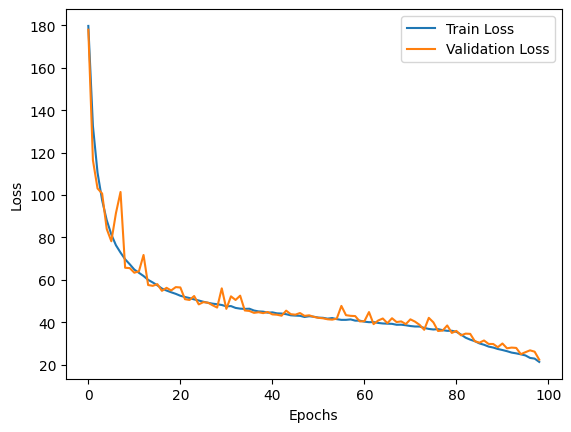

Inference Time per 1000 samples: 0.6400 seconds
Mean Squared Error (MSE): 22.6927
Mean Absolute Error (MAE): 3.4568
R-Squared (R²): 0.9858


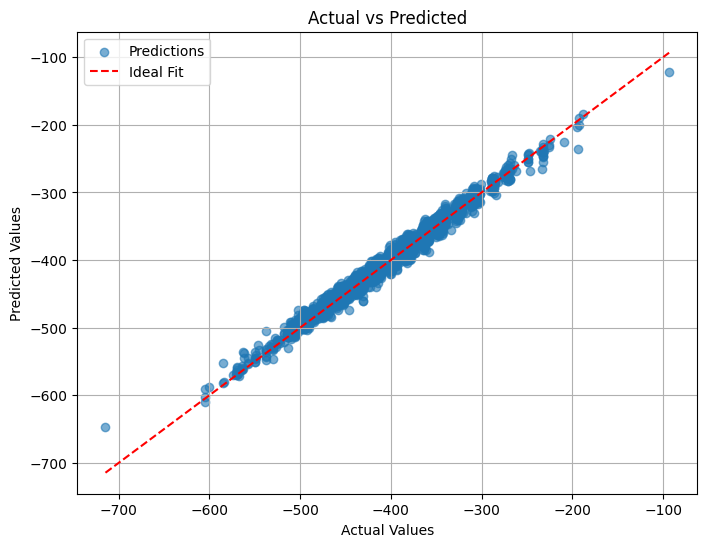

In [15]:
trained_model, test_loader, device = train_model(features, target, epochs=100, train_size=0.75)
evaluate_model(trained_model, test_loader, device)


Training with 60% of the data:


<ipython-input-14-48589b473efa>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
<ipython-input-14-48589b473efa>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
<ipython-input-14-48589b473efa>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = TensorDataset(t

Epoch [1/100], Train Loss: 7063.2026, Validation Loss: 266.4609
Epoch [2/100], Train Loss: 214.2181, Validation Loss: 175.7290
Epoch [3/100], Train Loss: 157.2732, Validation Loss: 144.7486
Epoch [4/100], Train Loss: 133.6418, Validation Loss: 122.7305
Epoch [5/100], Train Loss: 117.4606, Validation Loss: 112.2882
Epoch [6/100], Train Loss: 107.1677, Validation Loss: 99.4437
Epoch [7/100], Train Loss: 99.5133, Validation Loss: 93.0144
Epoch [8/100], Train Loss: 94.4012, Validation Loss: 91.1858
Epoch [9/100], Train Loss: 89.2144, Validation Loss: 83.6110
Epoch [10/100], Train Loss: 86.2361, Validation Loss: 82.3989
Epoch [11/100], Train Loss: 82.1868, Validation Loss: 78.3849
Epoch [12/100], Train Loss: 79.6078, Validation Loss: 75.0796
Epoch [13/100], Train Loss: 76.5883, Validation Loss: 73.9342
Epoch [14/100], Train Loss: 73.9655, Validation Loss: 71.2384
Epoch [15/100], Train Loss: 71.5255, Validation Loss: 82.6953
Epoch [16/100], Train Loss: 70.3056, Validation Loss: 69.6218
Epoch

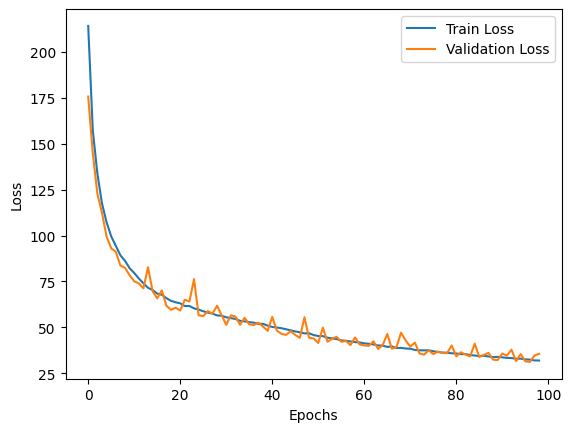

Inference Time per 1000 samples: 0.6672 seconds
Mean Squared Error (MSE): 35.7943
Mean Absolute Error (MAE): 4.4287
R-Squared (R²): 0.9773


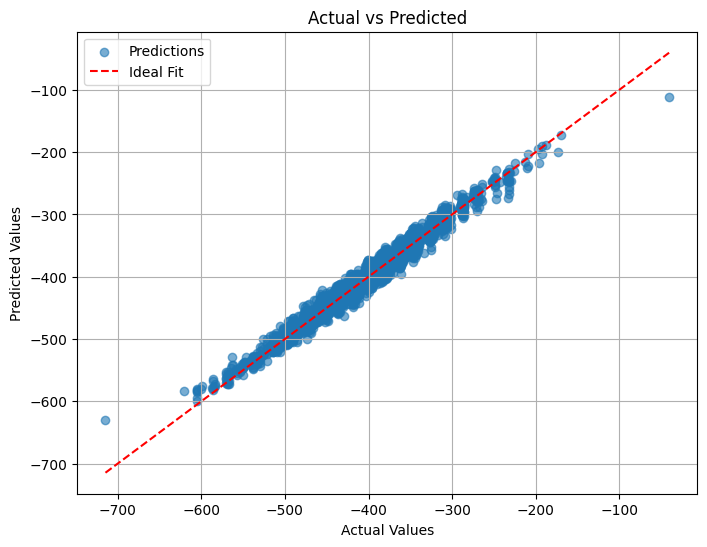

In [16]:
trained_model, test_loader, device = train_model(features, target, epochs=100, train_size=0.6)
evaluate_model(trained_model, test_loader, device)


Training with 45% of the data:


<ipython-input-14-48589b473efa>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
<ipython-input-14-48589b473efa>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
<ipython-input-14-48589b473efa>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = TensorDataset(t

Epoch [1/100], Train Loss: 9975.6267, Validation Loss: 337.7177
Epoch [2/100], Train Loss: 272.8794, Validation Loss: 217.4878
Epoch [3/100], Train Loss: 194.8665, Validation Loss: 168.4193
Epoch [4/100], Train Loss: 158.3477, Validation Loss: 143.5478
Epoch [5/100], Train Loss: 138.3168, Validation Loss: 133.4614
Epoch [6/100], Train Loss: 125.8267, Validation Loss: 115.8022
Epoch [7/100], Train Loss: 116.6492, Validation Loss: 109.0922
Epoch [8/100], Train Loss: 109.1975, Validation Loss: 101.9644
Epoch [9/100], Train Loss: 104.1982, Validation Loss: 106.2296
Epoch [10/100], Train Loss: 98.5443, Validation Loss: 96.6860
Epoch [11/100], Train Loss: 95.1163, Validation Loss: 90.2785
Epoch [12/100], Train Loss: 91.4598, Validation Loss: 86.1497
Epoch [13/100], Train Loss: 87.7674, Validation Loss: 85.7588
Epoch [14/100], Train Loss: 85.6062, Validation Loss: 81.4425
Epoch [15/100], Train Loss: 83.1344, Validation Loss: 77.4134
Epoch [16/100], Train Loss: 80.2812, Validation Loss: 76.850

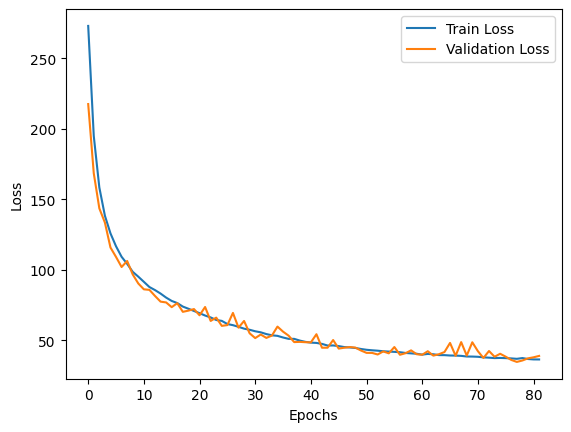

Inference Time per 1000 samples: 0.6477 seconds
Mean Squared Error (MSE): 39.5323
Mean Absolute Error (MAE): 4.4157
R-Squared (R²): 0.9755


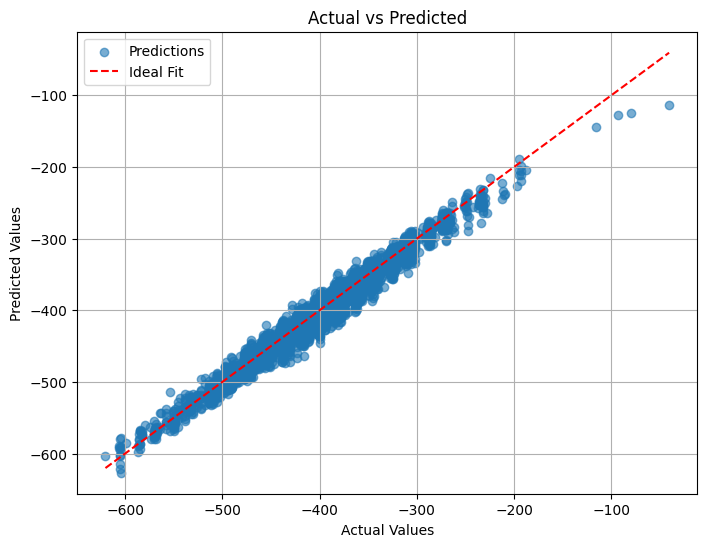

In [17]:
trained_model, test_loader, device = train_model(features, target, epochs=100, train_size=0.45)
evaluate_model(trained_model, test_loader, device)


Training with 30% of the data:


<ipython-input-14-48589b473efa>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
<ipython-input-14-48589b473efa>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
<ipython-input-14-48589b473efa>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = TensorDataset(t

Epoch [1/100], Train Loss: 13537.5226, Validation Loss: 408.2689
Epoch [2/100], Train Loss: 333.4154, Validation Loss: 285.9555
Epoch [3/100], Train Loss: 259.1768, Validation Loss: 235.3153
Epoch [4/100], Train Loss: 222.8527, Validation Loss: 204.3350
Epoch [5/100], Train Loss: 198.9345, Validation Loss: 180.1337
Epoch [6/100], Train Loss: 176.9924, Validation Loss: 160.8629
Epoch [7/100], Train Loss: 158.3997, Validation Loss: 169.4387
Epoch [8/100], Train Loss: 144.6656, Validation Loss: 133.7585
Epoch [9/100], Train Loss: 134.3239, Validation Loss: 129.8567
Epoch [10/100], Train Loss: 128.0300, Validation Loss: 120.8468
Epoch [11/100], Train Loss: 122.0899, Validation Loss: 115.3597
Epoch [12/100], Train Loss: 118.1037, Validation Loss: 116.0252
Epoch [13/100], Train Loss: 113.9703, Validation Loss: 109.2945
Epoch [14/100], Train Loss: 111.2314, Validation Loss: 120.6992
Epoch [15/100], Train Loss: 108.4541, Validation Loss: 102.1104
Epoch [16/100], Train Loss: 105.2287, Validatio

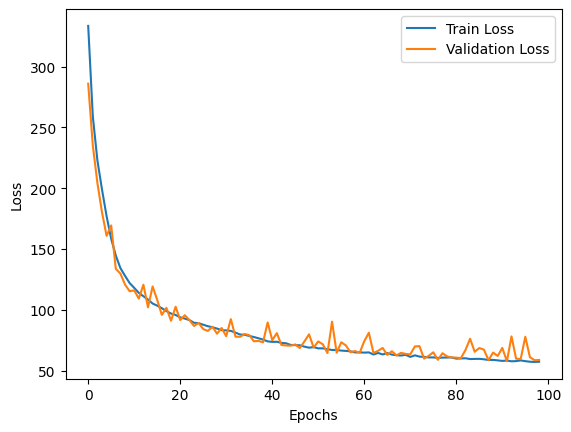

Inference Time per 1000 samples: 0.6722 seconds
Mean Squared Error (MSE): 58.8302
Mean Absolute Error (MAE): 5.8742
R-Squared (R²): 0.9635


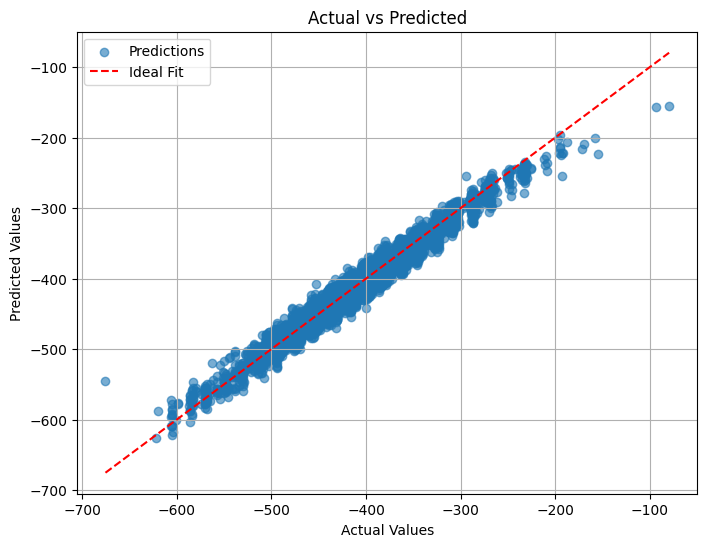

In [18]:
trained_model, test_loader, device = train_model(features, target, epochs=100, train_size=0.3)
evaluate_model(trained_model, test_loader, device)


Training with 15% of the data:


<ipython-input-14-48589b473efa>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
<ipython-input-14-48589b473efa>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
<ipython-input-14-48589b473efa>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = TensorDataset(t

Epoch [1/100], Train Loss: 25091.3683, Validation Loss: 721.4810
Epoch [2/100], Train Loss: 534.3161, Validation Loss: 389.7484
Epoch [3/100], Train Loss: 356.7455, Validation Loss: 307.8239
Epoch [4/100], Train Loss: 296.7119, Validation Loss: 283.2891
Epoch [5/100], Train Loss: 265.2779, Validation Loss: 262.4912
Epoch [6/100], Train Loss: 241.3660, Validation Loss: 228.8484
Epoch [7/100], Train Loss: 224.2893, Validation Loss: 210.5227
Epoch [8/100], Train Loss: 209.3950, Validation Loss: 197.3832
Epoch [9/100], Train Loss: 198.6752, Validation Loss: 191.1704
Epoch [10/100], Train Loss: 185.3740, Validation Loss: 173.7470
Epoch [11/100], Train Loss: 173.4275, Validation Loss: 166.8112
Epoch [12/100], Train Loss: 164.0639, Validation Loss: 165.2612
Epoch [13/100], Train Loss: 157.8071, Validation Loss: 149.9879
Epoch [14/100], Train Loss: 148.9934, Validation Loss: 141.5835
Epoch [15/100], Train Loss: 143.3715, Validation Loss: 140.9572
Epoch [16/100], Train Loss: 136.9532, Validatio

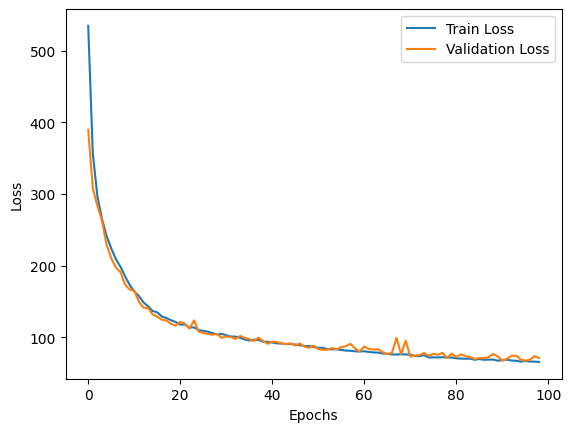

Inference Time per 1000 samples: 0.6388 seconds
Mean Squared Error (MSE): 71.9250
Mean Absolute Error (MAE): 6.4864
R-Squared (R²): 0.9554


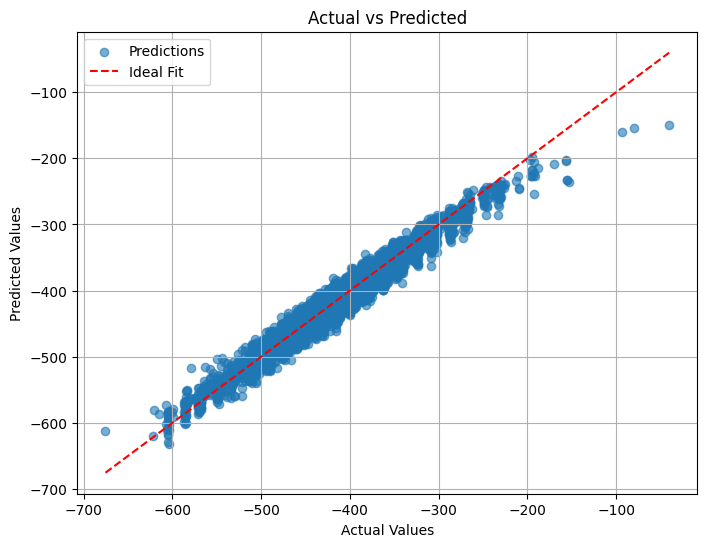

In [19]:
trained_model, test_loader, device = train_model(features, target, epochs=100, train_size=0.15)
evaluate_model(trained_model, test_loader, device)